In [1]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

# Load results from previous fit.

In [4]:
json_input_file = os.path.join(
    git_repo, 'BNP_sensitivity/GMM_clustering/iris_fits/bnp_full_data_fit_alpha1.0_iris.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [5]:
moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
#linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

In [6]:
moment_model.set_moments_from_free_par(best_param)
print(moment_model.moment_params)

Moment parameters:
	centroids:
[[ 4.19638440e-01 -8.37097629e-01  2.75327545e-01 -4.62478479e-02
  -4.21745484e-02 -1.92754121e-02 -7.40236945e-03 -2.76134574e-03
  -1.02517529e-03 -3.80561813e-04 -1.41629084e-04 -1.41629172e-04]
 [-1.79863877e-01  3.64128027e-01 -4.16666830e-01 -2.68597952e-01
  -1.57801023e-01 -6.50000343e-02 -2.42101262e-02 -8.93976914e-03
  -3.30535952e-03 -1.22321751e-03 -4.52561932e-04 -4.52561843e-04]
 [ 1.14176121e+00 -2.29445672e+00  1.67849510e+00  3.85234337e-01
   1.76144870e-01  6.56627817e-02  2.36691815e-02  8.64200759e-03
   3.18116266e-03  1.17401432e-03  4.32429982e-04  4.32429271e-04]
 [ 4.78664409e-01 -9.54591701e-01  3.12833980e-01  1.03837168e-01
   3.93148394e-02  1.39904738e-02  5.05094437e-03  1.85029392e-03
   6.81784243e-04  2.51297982e-04  9.20773775e-05  9.20777510e-05]]
	cluster_weights:
[6.57902217e-01 3.29192780e-01 8.19513422e-03 2.40071270e-03
 1.16052367e-03 5.75069104e-04 2.86893690e-04 1.43353394e-04
 7.16613229e-05 3.58280694e-05 1

In [7]:
print(model.prior_params)

prior_params:
	alpha: [1.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [8]:
alpha0 = model.prior_params['alpha'].get()[0]

# Define a perturbation in the logit v space.

In [9]:
# def log_phi(logit_v):
#     return - logit_v - np.log1p(np.exp(-logit_v))

# def phi(logit_v):
#     return np.exp(log_phi(logit_v))

# Define a perturbation in the logit v space.

phi_center = -2
#phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
phi_log_rescale = -np.log(0.5)
print(phi_log_rescale)
def log_phi(logit_v):
    return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

def phi(logit_v):
    return np.exp(log_phi(logit_v))



0.6931471805599453


This perturbation class is based on the contamination model

$$
p_c(\theta | \epsilon, \phi) =  p_0(\theta) \left(1 + \epsilon \phi(\theta) \right)
$$

This corresponds to Gustafson's linear model.  One big problem is that you must take $\epsilon \rightarrow \infty$.  Another is that, even if you set it up as a normalized mixture, the scale of the perturbation determines the derivative.  I think it is worth experimenting with the model

\begin{align}
p_c(\theta | \epsilon, \phi) &= p_0(\theta)^{1 - \epsilon} p_1(\theta)^\epsilon \\
& = p_0(\theta) \left(\frac{p_1(\theta)}{p_0(\theta)}\right)^\epsilon \\
& =: p_0(\theta) (C_1 \phi(\theta)) ^ \epsilon
\end{align}

because, among other things, it is invariant to the scaling $C_1$.


In [14]:
prior_perturbation = fun_sens_lib.PriorPerturbation(model, log_phi, logit_v_ub=8, logit_v_lb = -8)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

0.0 -1.930463414006729 -0.0006709222782391074 -1.9297913138637637


phi max:  0.4997727846542519


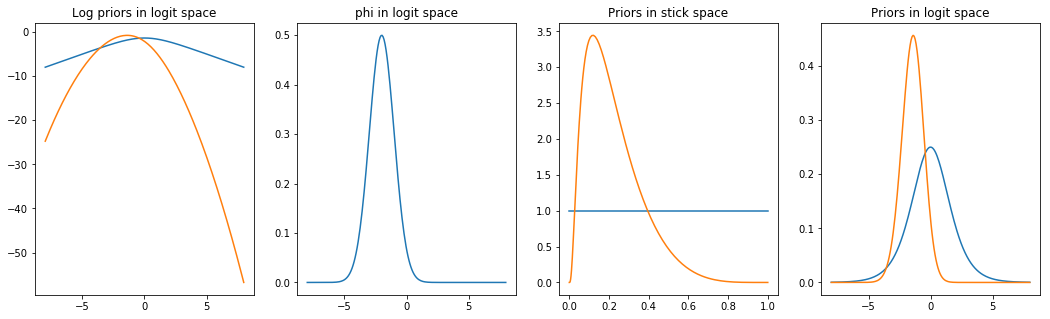

In [15]:
prior_perturbation.set_epsilon(1.0)

logit_v_grid = np.linspace(prior_perturbation.logit_v_lb, 
                               prior_perturbation.logit_v_ub, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, np.exp(prior_perturbation.log_phi(logit_v_grid)))
plt.title('phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


# Choose the number of GH points.

In [16]:
import LinearResponseVariationalBayes.ExponentialFamilies as ef
model.global_vb_params.set_free(best_param)
vb_params = deepcopy(model.vb_params)

prior_perturbation.set_epsilon(1.0)

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(
        prior_perturbation.model.vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        prior_perturbation.get_e_log_perturbation(sum_vector=False))

print(expected_perturbations_list[0])
expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / \
        np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
max_diffs = np.max(np.abs(diffs), axis=1)
print(max_diffs)
gh_deg_threshold = np.argmax(max_diffs < 1e-5)
gh_deg = max(20, gh_deg_threshold)
print(gh_deg, gh_deg_threshold, len(max_diffs))

[ 4.24187085 15.97290136  5.46304845  4.24500023  4.22199451  4.21736411
  4.21731728  4.21756875  4.21769752  4.21774986  4.21776973]
[2.10600315e-16 4.21180193e-16 6.31740185e-16 6.50316954e-16
 4.18767210e-16 2.10583667e-16 2.10602654e-16 4.21205307e-16
 6.31770289e-16 4.21205307e-16 4.21205307e-16 4.21205307e-16
 2.10602654e-16 4.18767210e-16 4.21180193e-16 4.21200630e-16
 2.10602654e-16 4.21162107e-16 4.44842596e-16 4.21200630e-16
 4.20738685e-16 2.22421298e-16 6.31800944e-16 2.10602654e-16
 2.10581054e-16 4.21200630e-16 6.31740185e-16 4.87737715e-16
 4.20738685e-16 2.10590096e-16 2.10602654e-16 4.21200630e-16
 2.10580062e-16 4.20738685e-16 4.21162107e-16 4.21160123e-16
 3.33631947e-16 2.10602654e-16 4.21200630e-16 2.10602654e-16
 4.21167334e-16 4.21162107e-16 4.21200630e-16 4.21200630e-16
 4.21205307e-16 4.21200630e-16 4.21167334e-16 2.10600315e-16
 2.10602654e-16 4.21205307e-16 2.10602654e-16 8.41477370e-16
 2.22421298e-16 3.33631947e-16 3.25158477e-16 2.10602654e-16
 3.33631947

In [17]:
# First fit with no perturbation but the increased number of gh points.

model.objective.logger.print_every = 10
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)

best_param_0, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=lambda x: gmm_utils.precondition_and_optimize(model.objective, x),
        init_x=best_param,
        initial_optimization_fun=None,
        max_iter=100,
        gtol=1e-8, ftol=1e-8, xtol=1e-8, disp=False,
        keep_intermediate_optimizations=True)

kl_hessian_0 = model.objective.fun_free_hessian(best_param_0)
    
print('Done. ')

Iter: 0	 RMSE: 12.421223178320895	 Objective: -337.15435233989535
Iter: 1	 RMSE: 12.421229104424624	 Objective: -337.15436409823667
Iter: 2	 RMSE: 12.421230925726721	 Objective: -337.1543641117851
Optimization terminated successfully.
         Current function value: -337.154364
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
Iter: 3	 RMSE: 12.421230925726721	 Objective: -337.1543641117861
Iter: 4	 RMSE: 12.42123092375581	 Objective: -337.15436411178933
Optimization terminated successfully.
         Current function value: -337.154364
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter: 5	 RMSE: 12.42123092375581	 Objective: -337.1543641117887
Iter: 6	 RMSE: 12.421230923735962	 Objective: -337.1543641117869
         Current function value: -337.154364
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
  

# Examine Fit 

In [12]:
pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)

In [13]:
# look at results
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [14]:
# we plot in PCA space
bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

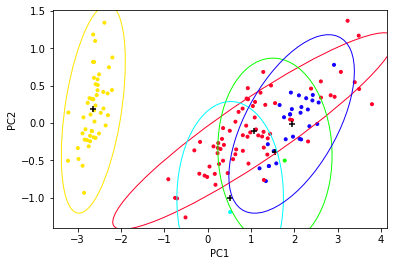

In [15]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

plt.savefig('../../../writing/functional_sensitivity_writing/parametric_sens_results/init_fit_alph8.0.png')

# Define prior perturbation

In [16]:
# This expects the hyperparameter to be at its optimal value.
prior_perturbation.set_epsilon(0.0)
epsilon_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=prior_perturbation.model.global_vb_params,
        output_par=moment_model.moment_params,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=moment_model.set_moments,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [17]:
prior_perturbation.get_e_log_perturbation()
np.linalg.norm(epsilon_sensitivity.get_dinput_dhyper())

0.3171455721592351

## Fit with perturbation

In [61]:
epsilon = 10.0 # prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
    epsilon, linear=True)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Epsilon:  10.0
Predicted differences:  3.171455721592351


In [62]:
# Then fit with the perturbation.
prior_perturbation.set_epsilon(epsilon)
print(prior_perturbation.epsilon_param)
best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=
            lambda x: gmm_utils.precondition_and_optimize(
                prior_perturbation.objective, x),
        init_x=best_param_phi_pred,
        initial_optimization_fun=None,
        keep_intermediate_optimizations=True)

output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

print('Done. Converged: ', converged)

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.785481e-08
  AccuracyWarning)


epsilon: 10.0
Iter  0  value:  -289.0068512810271
Iter  1  value:  -290.20244320189875
Iter  2  value:  -290.59484743452816
Iter  3  value:  -290.6808067573514
Iter  4  value:  -290.6962463075964
Iter  5  value:  -290.69897204317607
Iter  6  value:  -290.6990719959755
Iter  7  value:  -290.69907273035534
Iter  8  value:  -290.6990727306138
Optimization terminated successfully.
         Current function value: -290.699073
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Hessian evaluations: 0
Iter  9  value:  -290.699072730613
Iter  10  value:  -290.6990727306151
         Current function value: -290.699073
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 2.0200410418608494


Epsilon: 10.0


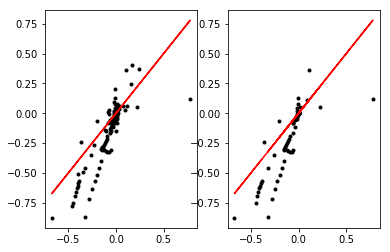

In [63]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

plt.subplot(1, 2, 2)
plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [64]:
_ = model.set_from_global_free_par(best_param_0)
print('original expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

original expected number of clusters:  8.514556633215292


In [65]:
_ = model.set_from_global_free_par(best_param_phi)
print('perturbed expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

perturbed expected number of clusters:  8.247135285294867


In [66]:
_ = model.set_from_global_free_par(best_param_phi_pred)
print('predicted expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

predicted expected number of clusters:  8.059719783322123


# Predict for a range of perturbations

In [24]:
epsilon_vec = np.arange(-7, 15)
print(epsilon_vec)

[-7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [25]:
best_param_phi_array = []
best_param_phi_pred_array = []

output_phi_array = []
output_phi_pred_array = []

In [26]:
best_param_phi_array = np.load('./best_param_phi_array.npy')

In [70]:
np.save('best_param_phi_array', best_param_phi_array)

In [27]:
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


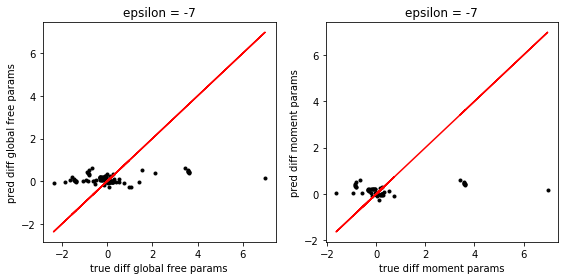

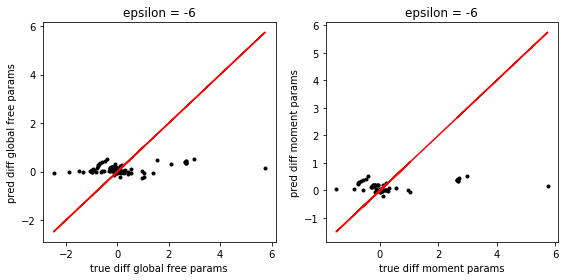

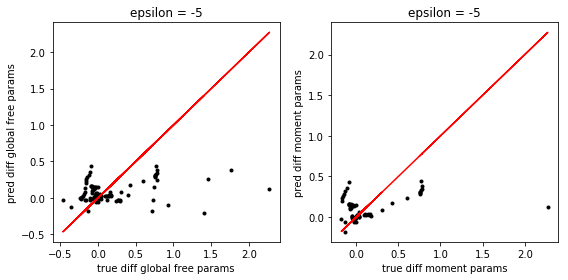

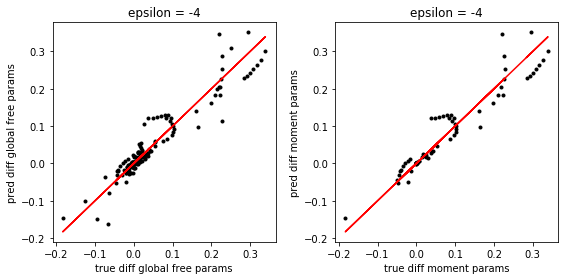

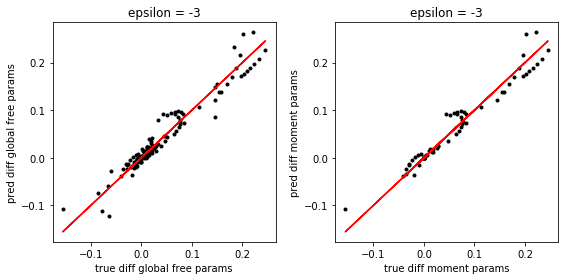

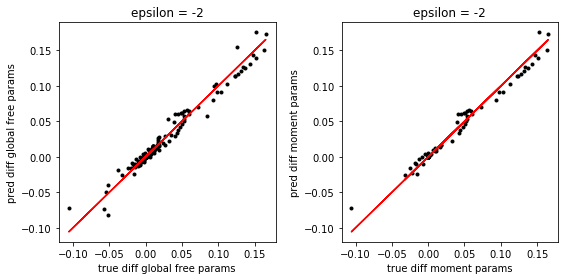

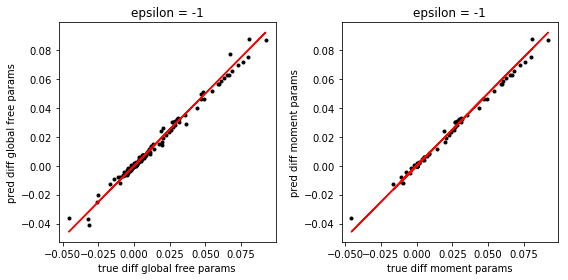

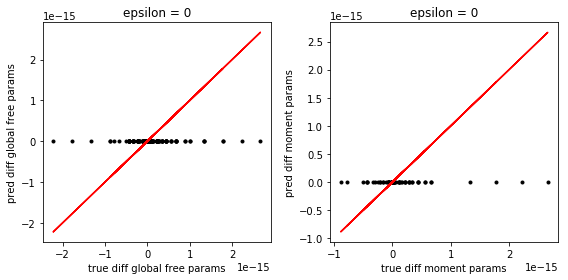

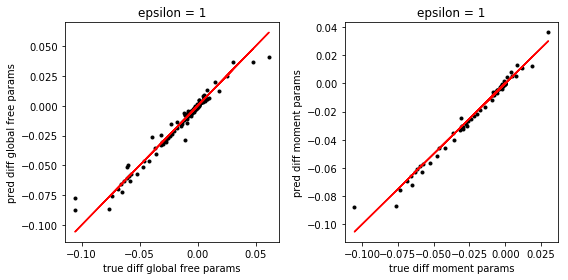

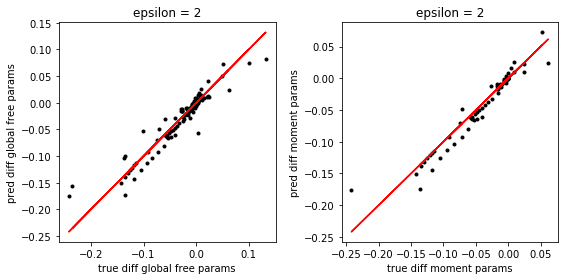

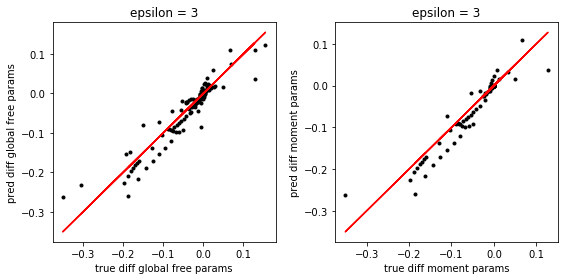

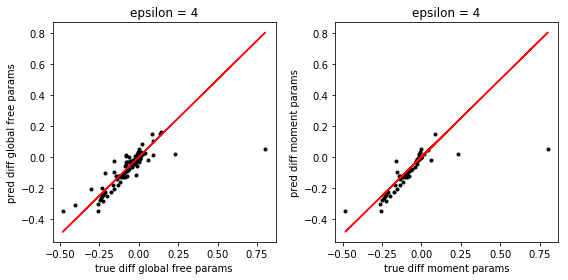

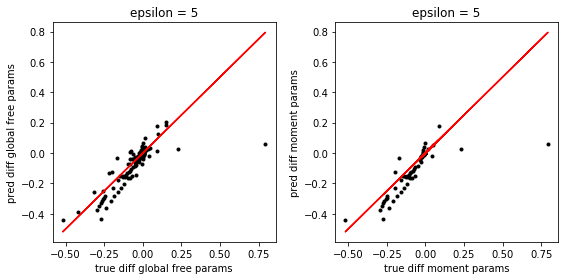

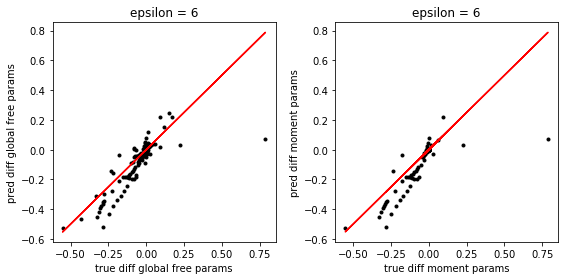

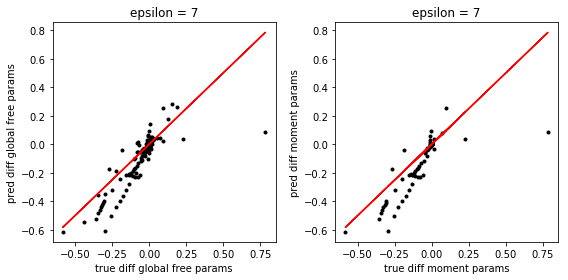

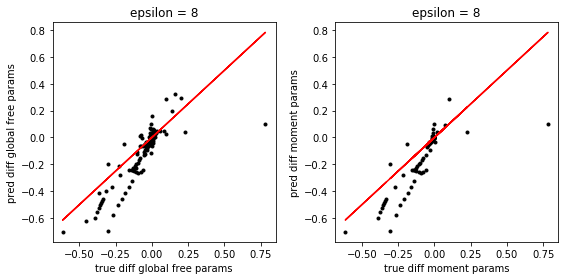

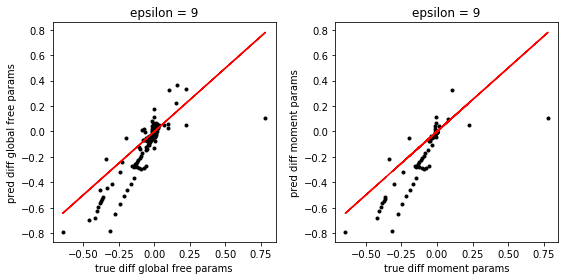

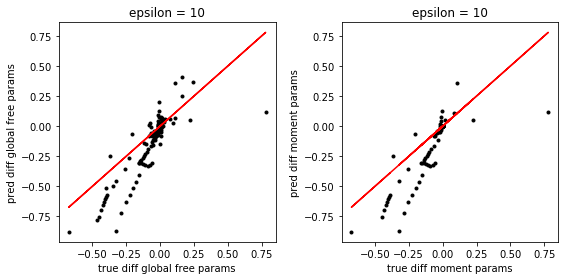

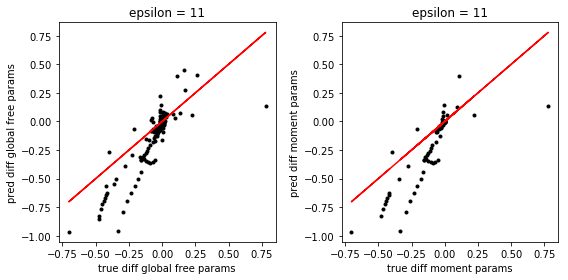

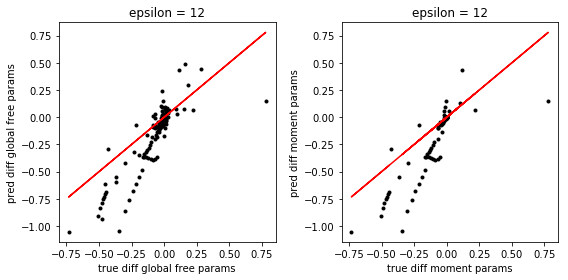

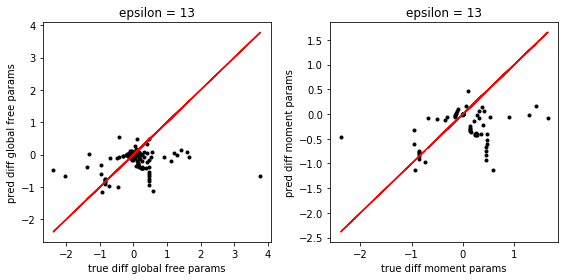

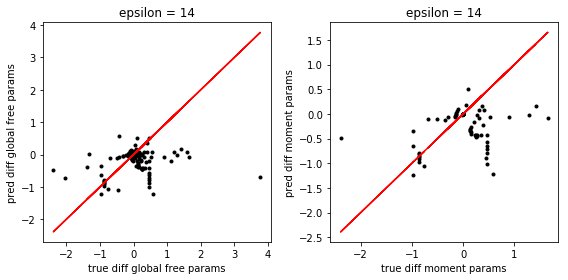

In [72]:
for i in range(len(epsilon_vec)): 
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(best_param_phi_array[i] - best_param_0, 
             best_param_phi_pred_array[i] - best_param_0, 'k.')
    plt.plot(best_param_phi_array[i] - best_param_0, 
             best_param_phi_array[i] - best_param_0, 'r')
    plt.xlabel('true diff global free params')
    plt.ylabel('pred diff global free params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))

    plt.subplot(1, 2, 2)
    plt.plot(output_phi_array[i] - output_0, 
             output_phi_pred_array[i] - output_0, 'k.')
    plt.plot(output_phi_array[i] - output_0, 
             output_phi_array[i] - output_0, 'r')
    plt.xlabel('true diff moment params')
    plt.ylabel('pred diff moment params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))
    
    plt.tight_layout()

    

# Lets also look at the expected number of clusters

In [28]:
# This expects the hyperparameter to be at its optimal value.
e_num_clusters_class = gmm_utils.ExpectedNumClusters(model)
e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

prior_perturbation.set_epsilon(0.0)
cluster_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=e_num_clusters_class.model.global_vb_params,
        output_par=e_num_clusters_class.e_num_clusters,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=e_num_clusters_class.set_e_num_clusters,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [31]:
e_num_clusters_pred = []
e_num_clusters_true = []
for i in range(len(epsilon_vec)): 
    e_num_clusters_true.append(
            e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_phi_array[i]))
    
    e_num_clusters_pred.append(
        cluster_sensitivity.predict_output_par_from_hyperparameters(epsilon_vec[i], linear = False))

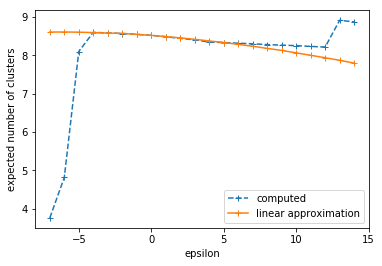

In [32]:
plt.plot(epsilon_vec, e_num_clusters_true, '+--')
plt.plot(epsilon_vec, e_num_clusters_pred, '+-')

plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')

plt.legend(('computed', 'linear approximation'))

# plt.savefig('../../../writing/functional_sensitivity_writing/parametric_sens_results/pred_num_clusters.png')

In [32]:
def plot_results_from_free_params(model, global_free_params, fig): 
    # look at results
    model.global_vb_params.set_free(global_free_params)
    model.set_optimal_z()

    bnp_clusters = np.argmax(model.e_z, axis = 1)
    bnp_centroids = model.vb_params['global']['centroids'].get()

    bnp_cluster_infos = model.vb_params['global']['gamma'].get()
    bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)
    
    pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)
    
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)
        
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

    fig.set_xlabel('PC1')
    fig.set_ylabel('PC2')


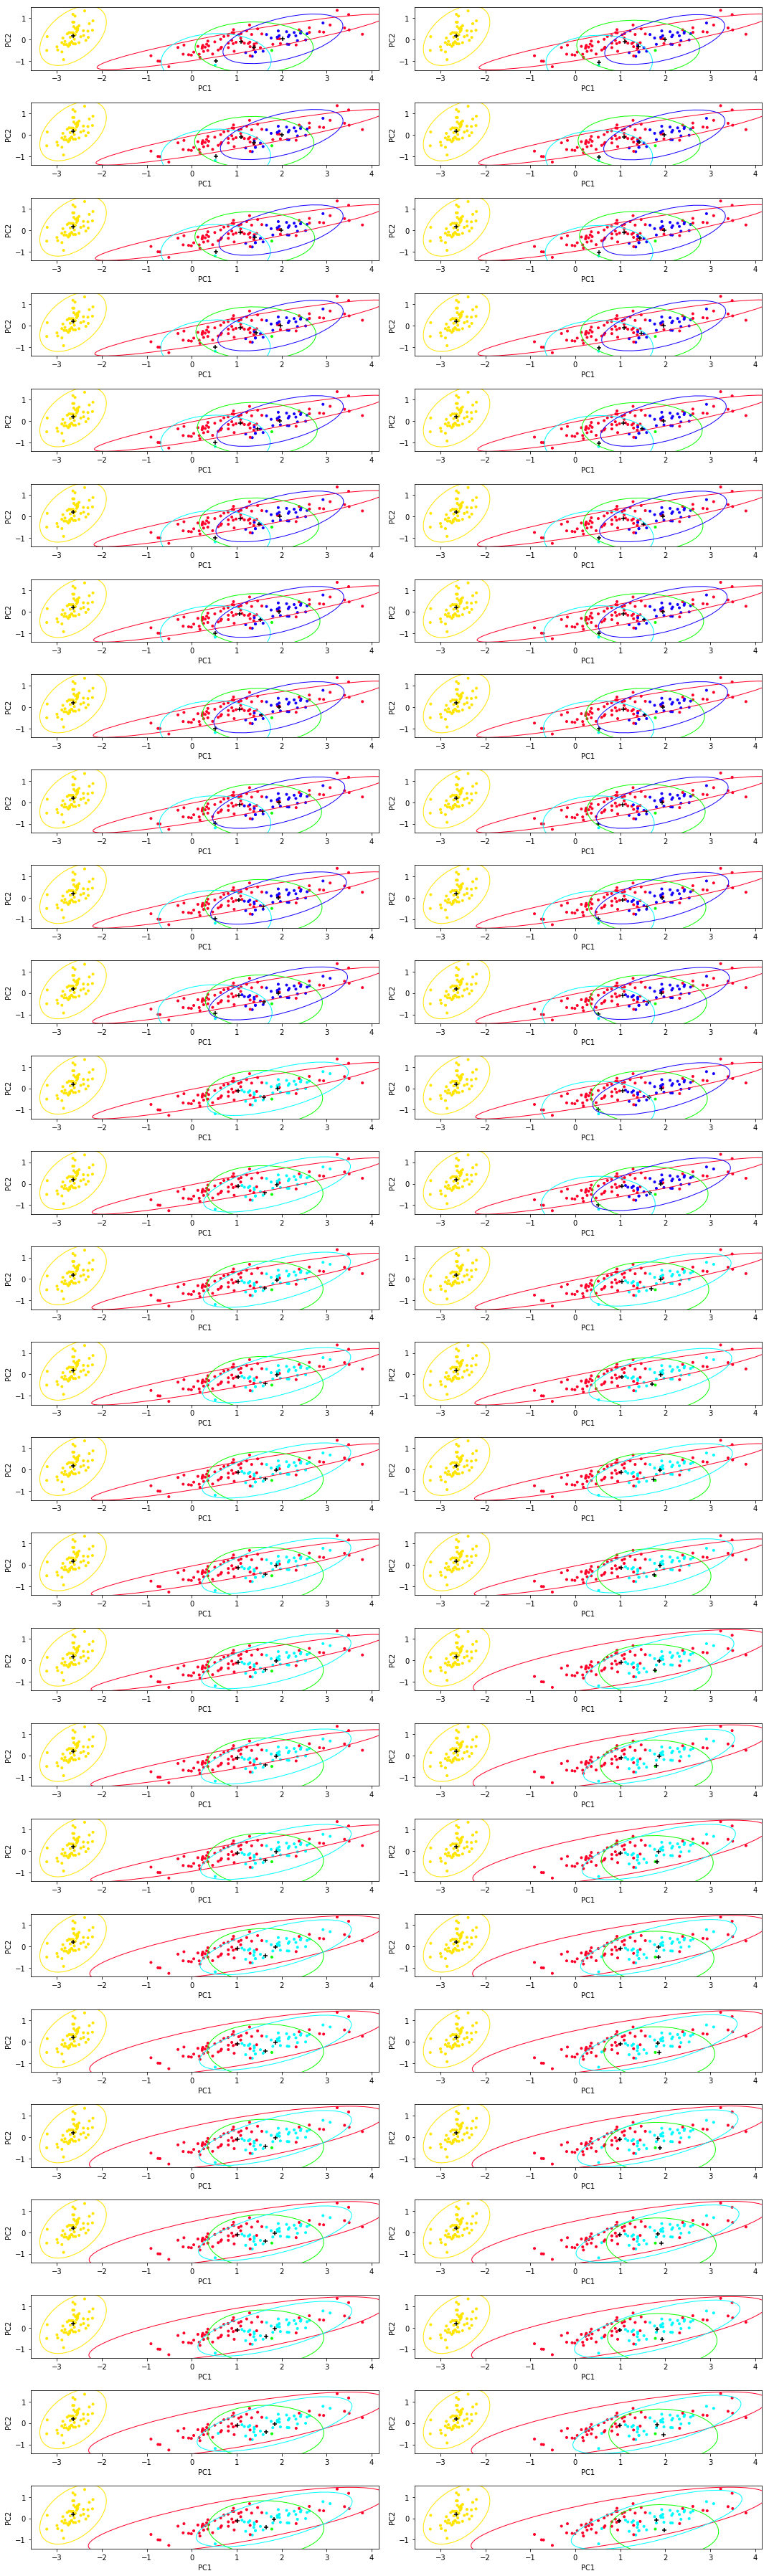

In [33]:
f, axarr = plt.subplots(len(epsilon_vec), 2, figsize = (15, 50))

for i in range(len(epsilon_vec)): 
    plot_results_from_free_params(model, best_param_phi_array[i], axarr[i, 0])
    plot_results_from_free_params(model, best_param_phi_pred_array[i], axarr[i, 1])

f.tight_layout()